# Temporal evolution of subsurface Pacific temperature biases

Note, I am using 16 cores and 64 Gb memory for this calculation.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cmocean as cm
import pandas as pd
import cftime
from dask.distributed import Client

In [2]:
# OOD
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=4,memory="31GB",walltime='6:00:00')
client = Client(cluster)
cluster.scale(cores=12)

In [5]:
client

Client Scheduler: tcp://10.0.96.128:35083 Dashboard: http://10.0.96.128:37463/status,Cluster Workers: 12 Cores: 12 Memory: 86.64 GiB


In [4]:
session = cc.database.create_session()

# Pacific

We will only consider data between -190° and -130° as the best indicator of the size of Pacific temperature biases.

In [6]:
# This is for tropical and subtropical Pacific
transect_lons = [-190, -130]  
transect_lats = [-35,35]     

KELVIN_TO_CELSIUS = -273.15

## Zonal average view

Let's plot what the zonal biases look like in cycle 1 of the IAF simulation, and select areas over which the biases are largest.

In [7]:
expt = '01deg_jra55v140_iaf'
tstart = '2000-01-01'
tend = '2003-12-31'
temp = cc.querying.getvar(expt, 'temp', session, ncfile='ocean-3d-temp-1-monthly-mean-ym_%.nc')#,chunks={'st_ocean':20,'xt_ocean':100,'yt_ocean':100,'time':None})
temperature = temp.sel(yt_ocean=slice(transect_lats[0],transect_lats[1])).sel(xt_ocean=slice(transect_lons[0],transect_lons[1])).mean('xt_ocean').sel(time=slice(tstart,tend)).mean('time').load() + KELVIN_TO_CELSIUS

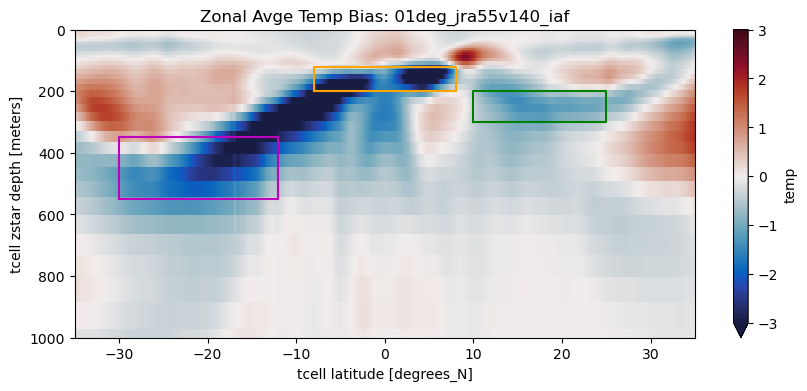

In [8]:
# Load obs 
ds_obs = xr.open_mfdataset('/g/data/ik11/observations/woa13/01/woa13_ts_??_mom01.nc')#,chunks={'ZT':20,'GRID_X_T':100,'GRID_Y_T':100,'time':None})
ds_obs = ds_obs.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
ds_obs['st_ocean'] = temp.st_ocean
ds_obs['xt_ocean'] = temp.xt_ocean
ds_obs['yt_ocean'] = temp.yt_ocean
ds_obs = ds_obs.sel(yt_ocean=slice(transect_lats[0],transect_lats[1])).sel(xt_ocean=slice(transect_lons[0],transect_lons[1])).mean('xt_ocean').mean('time')
temperature_obs = ds_obs.temp.load()

plt.figure(figsize=(10,4))
temp_bias = temperature-temperature_obs
temp_bias.plot(yincrease=False,vmin=-3, vmax=3,cmap = cm.cm.balance)
plt.ylim(ymin=1000)
plt.title('Zonal Avge Temp Bias: '+expt)
# Define 3 regions
r1 = {'minlat':-30,'maxlat':-12,'upperdepth':350,'lowerdepth':550}
r2 = {'minlat':-8,'maxlat':8,'upperdepth':120,'lowerdepth':200}
r3 = {'minlat':10,'maxlat':25,'upperdepth':200,'lowerdepth':300}
plt.plot([r1['minlat'], r1['maxlat'], r1['maxlat'], r1['minlat'], r1['minlat']],
         [r1['lowerdepth'], r1['lowerdepth'], r1['upperdepth'], r1['upperdepth'], r1['lowerdepth']],'m')
plt.plot([r2['minlat'], r2['maxlat'], r2['maxlat'], r2['minlat'], r2['minlat']],
         [r2['lowerdepth'], r2['lowerdepth'], r2['upperdepth'], r2['upperdepth'], r2['lowerdepth']],'orange')
plt.plot([r3['minlat'], r3['maxlat'], r3['maxlat'], r3['minlat'], r3['minlat']],
         [r3['lowerdepth'], r3['lowerdepth'], r3['upperdepth'], r3['upperdepth'], r3['lowerdepth']],'g')

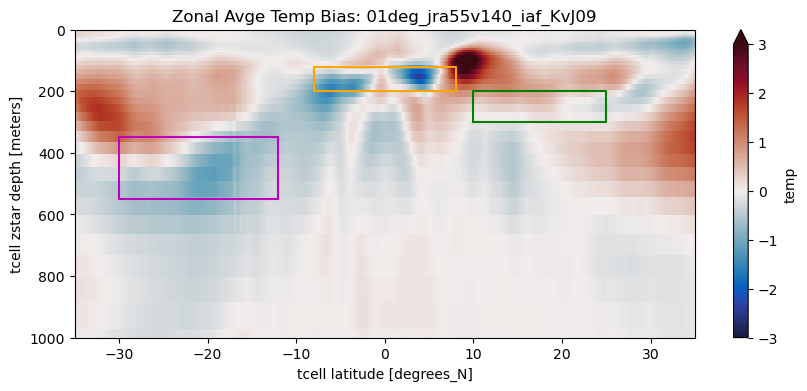

In [9]:
expt = '01deg_jra55v140_iaf_KvJ09'
temp = cc.querying.getvar(expt, 'temp', session, ncfile='ocean-3d-temp-1-monthly-mean-ym_%.nc')#,chunks={'st_ocean':20,'xt_ocean':100,'yt_ocean':100,'time':None})
temperature = temp.sel(yt_ocean=slice(transect_lats[0],transect_lats[1])).sel(xt_ocean=slice(transect_lons[0],transect_lons[1])).mean('xt_ocean').sel(time=slice(tstart,tend)).mean('time').load() + KELVIN_TO_CELSIUS

plt.figure(figsize=(10,4))
temp_bias = temperature-temperature_obs
temp_bias.plot(yincrease=False,vmin=-3, vmax=3,cmap = cm.cm.balance)
plt.ylim(ymin=1000)
plt.title('Zonal Avge Temp Bias: '+expt)

plt.plot([r1['minlat'], r1['maxlat'], r1['maxlat'], r1['minlat'], r1['minlat']],
         [r1['lowerdepth'], r1['lowerdepth'], r1['upperdepth'], r1['upperdepth'], r1['lowerdepth']],'m')
plt.plot([r2['minlat'], r2['maxlat'], r2['maxlat'], r2['minlat'], r2['minlat']],
         [r2['lowerdepth'], r2['lowerdepth'], r2['upperdepth'], r2['upperdepth'], r2['lowerdepth']],'orange')
plt.plot([r3['minlat'], r3['maxlat'], r3['maxlat'], r3['minlat'], r3['minlat']],
         [r3['lowerdepth'], r3['lowerdepth'], r3['upperdepth'], r3['upperdepth'], r3['lowerdepth']],'g')

**The 3 regions defined above here separate the shallow Equatorial bias from deeper southern subtropical biases, and intermediate-depth weaker biases in the northern tropics.**

## Plot timeseries in each Pacific region for IAF runs

In [10]:
def extract_timeseries(expt,rx,monthly=False, start_time=None, end_time=None):
    try:
        temp = cc.querying.getvar(expt, 'temp', session, ncfile='ocean-3d-temp-1-monthly-mean-ym_%.nc',start_time=start_time, end_time=end_time)
    except:
        temp = cc.querying.getvar(expt, 'temp', session, ncfile='ocean.nc',start_time=start_time, end_time=end_time)
    if(monthly):
        temp_ts = temp.sel(yt_ocean=slice(rx['minlat'],rx['maxlat'])).mean('yt_ocean')\
                .sel(xt_ocean=slice(transect_lons[0],transect_lons[1])).mean('xt_ocean')\
                .sel(st_ocean=slice(rx['upperdepth'],rx['lowerdepth'])).mean('st_ocean').load() + KELVIN_TO_CELSIUS
    else:
        temp_ts = temp.sel(yt_ocean=slice(rx['minlat'],rx['maxlat'])).mean('yt_ocean')\
                .sel(xt_ocean=slice(transect_lons[0],transect_lons[1])).mean('xt_ocean')\
                .sel(st_ocean=slice(rx['upperdepth'],rx['lowerdepth'])).mean('st_ocean')\
                .groupby('time.year').mean(dim='time').load() + KELVIN_TO_CELSIUS
    return temp_ts

In [11]:
temp_r1_obs = ds_obs.temp.sel(yt_ocean=slice(r1['minlat'],r1['maxlat'])).mean('yt_ocean')\
                .sel(st_ocean=slice(r1['upperdepth'],r1['lowerdepth'])).mean('st_ocean').load()
temp_r2_obs = ds_obs.temp.sel(yt_ocean=slice(r2['minlat'],r2['maxlat'])).mean('yt_ocean')\
                .sel(st_ocean=slice(r2['upperdepth'],r2['lowerdepth'])).mean('st_ocean').load()
temp_r3_obs = ds_obs.temp.sel(yt_ocean=slice(r3['minlat'],r3['maxlat'])).mean('yt_ocean')\
                .sel(st_ocean=slice(r3['upperdepth'],r3['lowerdepth'])).mean('st_ocean').load()

Text(0.5, 1.0, '(c) Northern Tropical Pacific Intermediate-depth Bias')

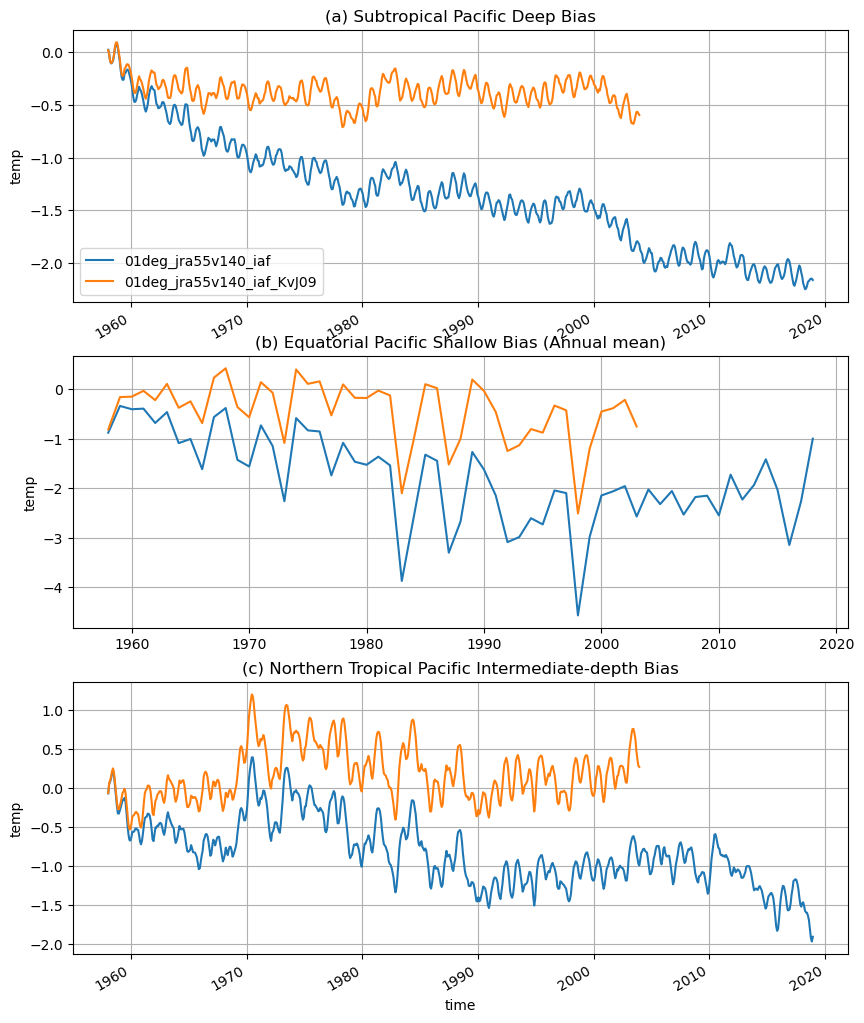

In [12]:
expts = ['01deg_jra55v140_iaf','01deg_jra55v140_iaf_KvJ09']
start_time='1958-01-01'
end_time='2019-01-01'
plt.figure(figsize=(10,12))
plt.subplot(311)
for e in expts:
    temp_bias = extract_timeseries(e,r1,monthly=True,start_time=start_time,end_time=end_time) - temp_r1_obs
    temp_bias.plot(label=e)
plt.legend()
plt.xlabel('')
plt.grid()
plt.title('(a) Subtropical Pacific Deep Bias')

plt.subplot(312)
for e in expts:
    temp_bias = extract_timeseries(e,r2,start_time=start_time,end_time=end_time) - temp_r2_obs
    temp_bias.plot(label=e)
plt.grid()
plt.title('(b) Equatorial Pacific Shallow Bias (Annual mean)')
plt.xlabel('')

plt.subplot(313)
for e in expts:
    temp_bias = extract_timeseries(e,r3,monthly=True,start_time=start_time,end_time=end_time) - temp_r3_obs
    temp_bias.plot(label=e)
plt.grid()
plt.title('(c) Northern Tropical Pacific Intermediate-depth Bias')

# And now for the Atlantic

In [13]:
# This is for tropical and subtropical Atlantic
transect_lons = [-50, -10]  
transect_lats = [-35,35]     

KELVIN_TO_CELSIUS = -273.15

In [14]:
expt = '01deg_jra55v140_iaf'
tstart = '1981-01-01'
tend = '1981-12-31'
temp = cc.querying.getvar(expt, 'temp', session, ncfile='ocean-3d-temp-1-monthly-mean-ym_%.nc')#,chunks={'st_ocean':20,'xt_ocean':100,'yt_ocean':100,'time':None})
temperature = temp.sel(yt_ocean=slice(transect_lats[0],transect_lats[1])).sel(xt_ocean=slice(transect_lons[0],transect_lons[1])).mean('xt_ocean').sel(time=slice(tstart,tend)).mean('time').load() + KELVIN_TO_CELSIUS

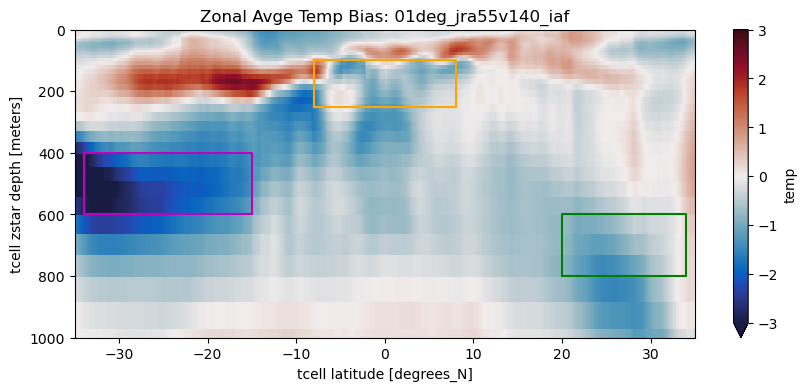

In [15]:
# Load obs 
ds_obs = xr.open_mfdataset('/g/data/ik11/observations/woa13/01/woa13_ts_??_mom01.nc')#,chunks={'ZT':20,'GRID_X_T':100,'GRID_Y_T':100,'time':None})
ds_obs = ds_obs.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
ds_obs['st_ocean'] = temp.st_ocean
ds_obs['xt_ocean'] = temp.xt_ocean
ds_obs['yt_ocean'] = temp.yt_ocean
ds_obs = ds_obs.sel(yt_ocean=slice(transect_lats[0],transect_lats[1])).sel(xt_ocean=slice(transect_lons[0],transect_lons[1])).mean('xt_ocean').mean('time')
temperature_obs = ds_obs.temp.load()

plt.figure(figsize=(10,4))
temp_bias = temperature-temperature_obs
temp_bias.plot(yincrease=False,vmin=-3, vmax=3,cmap = cm.cm.balance)
plt.ylim(ymin=1000)
plt.title('Zonal Avge Temp Bias: '+expt)
# Define 3 regions
r1 = {'minlat':-34,'maxlat':-15,'upperdepth':400,'lowerdepth':600}
r2 = {'minlat':-8,'maxlat':8,'upperdepth':100,'lowerdepth':250}
r3 = {'minlat':20,'maxlat':34,'upperdepth':600,'lowerdepth':800}
plt.plot([r1['minlat'], r1['maxlat'], r1['maxlat'], r1['minlat'], r1['minlat']],
         [r1['lowerdepth'], r1['lowerdepth'], r1['upperdepth'], r1['upperdepth'], r1['lowerdepth']],'m')
plt.plot([r2['minlat'], r2['maxlat'], r2['maxlat'], r2['minlat'], r2['minlat']],
         [r2['lowerdepth'], r2['lowerdepth'], r2['upperdepth'], r2['upperdepth'], r2['lowerdepth']],'orange')
plt.plot([r3['minlat'], r3['maxlat'], r3['maxlat'], r3['minlat'], r3['minlat']],
         [r3['lowerdepth'], r3['lowerdepth'], r3['upperdepth'], r3['upperdepth'], r3['lowerdepth']],'g')

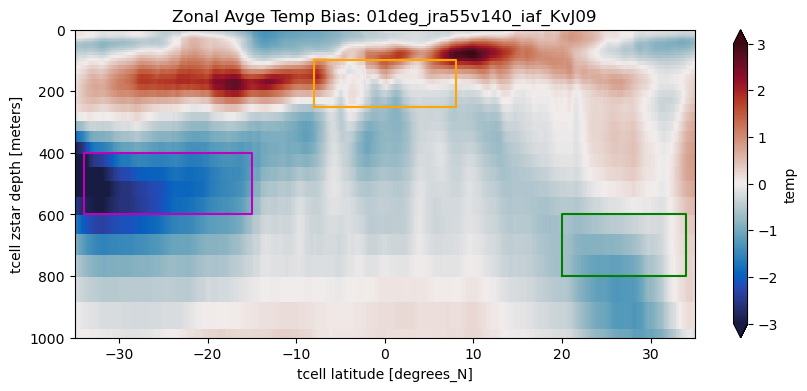

In [16]:
expt = '01deg_jra55v140_iaf_KvJ09'
temp = cc.querying.getvar(expt, 'temp', session, ncfile='ocean-3d-temp-1-monthly-mean-ym_%.nc')#,chunks={'st_ocean':20,'xt_ocean':100,'yt_ocean':100,'time':None})
temperature = temp.sel(yt_ocean=slice(transect_lats[0],transect_lats[1])).sel(xt_ocean=slice(transect_lons[0],transect_lons[1])).mean('xt_ocean').sel(time=slice(tstart,tend)).mean('time').load() + KELVIN_TO_CELSIUS

plt.figure(figsize=(10,4))
temp_bias = temperature-temperature_obs
temp_bias.plot(yincrease=False,vmin=-3, vmax=3,cmap = cm.cm.balance)
plt.ylim(ymin=1000)
plt.title('Zonal Avge Temp Bias: '+expt)

plt.plot([r1['minlat'], r1['maxlat'], r1['maxlat'], r1['minlat'], r1['minlat']],
         [r1['lowerdepth'], r1['lowerdepth'], r1['upperdepth'], r1['upperdepth'], r1['lowerdepth']],'m')
plt.plot([r2['minlat'], r2['maxlat'], r2['maxlat'], r2['minlat'], r2['minlat']],
         [r2['lowerdepth'], r2['lowerdepth'], r2['upperdepth'], r2['upperdepth'], r2['lowerdepth']],'orange')
plt.plot([r3['minlat'], r3['maxlat'], r3['maxlat'], r3['minlat'], r3['minlat']],
         [r3['lowerdepth'], r3['lowerdepth'], r3['upperdepth'], r3['upperdepth'], r3['lowerdepth']],'g')

**The 3 regions defined above**

### Plot timeseries in each Altantic region for IAF runs

In [17]:
temp_r1_obs = ds_obs.temp.sel(yt_ocean=slice(r1['minlat'],r1['maxlat'])).mean('yt_ocean')\
                .sel(st_ocean=slice(r1['upperdepth'],r1['lowerdepth'])).mean('st_ocean').load()
temp_r2_obs = ds_obs.temp.sel(yt_ocean=slice(r2['minlat'],r2['maxlat'])).mean('yt_ocean')\
                .sel(st_ocean=slice(r2['upperdepth'],r2['lowerdepth'])).mean('st_ocean').load()
temp_r3_obs = ds_obs.temp.sel(yt_ocean=slice(r3['minlat'],r3['maxlat'])).mean('yt_ocean')\
                .sel(st_ocean=slice(r3['upperdepth'],r3['lowerdepth'])).mean('st_ocean').load()

Text(0.5, 1.0, '(c) Northern Tropical Atlantic Intermediate-depth Bias')

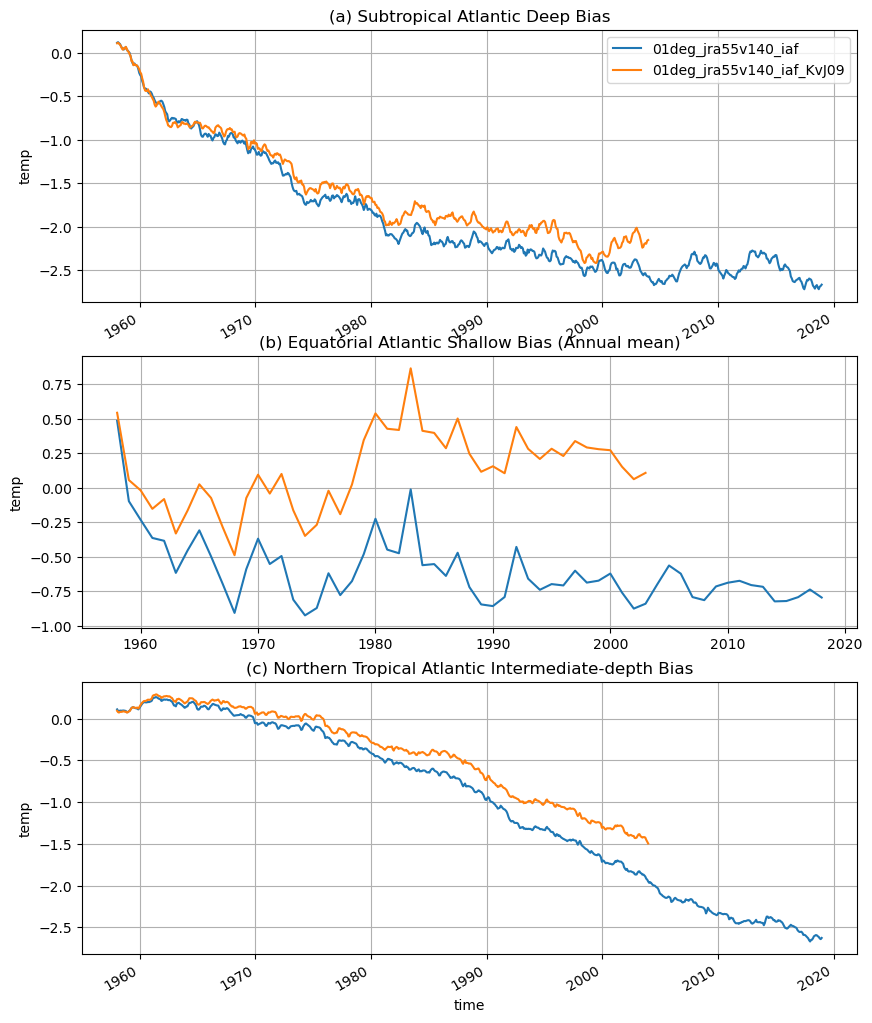

In [18]:
expts = ['01deg_jra55v140_iaf','01deg_jra55v140_iaf_KvJ09']
start_time='1958-01-01'
end_time='2019-01-01'
plt.figure(figsize=(10,12))
plt.subplot(311)
for e in expts:
    temp_bias = extract_timeseries(e,r1,monthly=True,start_time=start_time,end_time=end_time) - temp_r1_obs
    temp_bias.plot(label=e)
plt.legend()
plt.xlabel('')
plt.grid()
plt.title('(a) Subtropical Atlantic Deep Bias')

plt.subplot(312)
for e in expts:
    temp_bias = extract_timeseries(e,r2,start_time=start_time,end_time=end_time) - temp_r2_obs
    temp_bias.plot(label=e)
plt.grid()
plt.title('(b) Equatorial Atlantic Shallow Bias (Annual mean)')
plt.xlabel('')

plt.subplot(313)
for e in expts:
    temp_bias = extract_timeseries(e,r3,monthly=True,start_time=start_time,end_time=end_time) - temp_r3_obs
    temp_bias.plot(label=e)
plt.grid()
plt.title('(c) Northern Tropical Atlantic Intermediate-depth Bias')